# Inference of Anomaly Cross Correlation skill in multi-year hindcast evaluation

A demonstration using synthetic, independent (AR) "hindcast" and "observed" series.

**Please chime in at any point**

In [211]:
import numpy as np

import xarray as xr

import matplotlib
import matplotlib.pyplot as plt

from src import utils, plot, stats, ar_model

In [2]:
DATA_DIR = "../../../Squire_2022_CAFE-f6/data/"

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [11]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12

## We construct some synthetic series by fitting an Autoregressive model to the Atlantice multidecadal variability index computed from the CanESM5 CMIP6 DCPP hindcasts/forecasts

In [350]:
had = xr.open_zarr(
    f"{DATA_DIR}/processed/HadISST.annual-Jan.anom_1991-2020.sst_global.zarr"
)
ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5.annual.anom_1985-2014.sst_global.zarr"
)

In [351]:
amv = utils.calculate_AMV_index(utils.get_hindcast_rolling_mean(can["sst"], [4, 8]))

# amv = utils.calculate_AMV_index(had["sst"])
# spg = utils.extract_subpolar_gyre_region(had["sst"])

The synthetic observations are generated by randomly drawing $N_{time}$ samples of the AR model

The synthetic ensemble hindcasts are generated by running the model forward in time from $N_{time}$ randomly drawn samples of the AR model. The initial condition for each $N_{member}$ ensemble member is the same, but their trajectories differ because the noise component is different for each member.

Below, I generate $N_{sample}=5000$ pairs of such signals

In [387]:
N_time = 50
N_samples = 5000
N_members = 40
rolling_means = [4, 8]

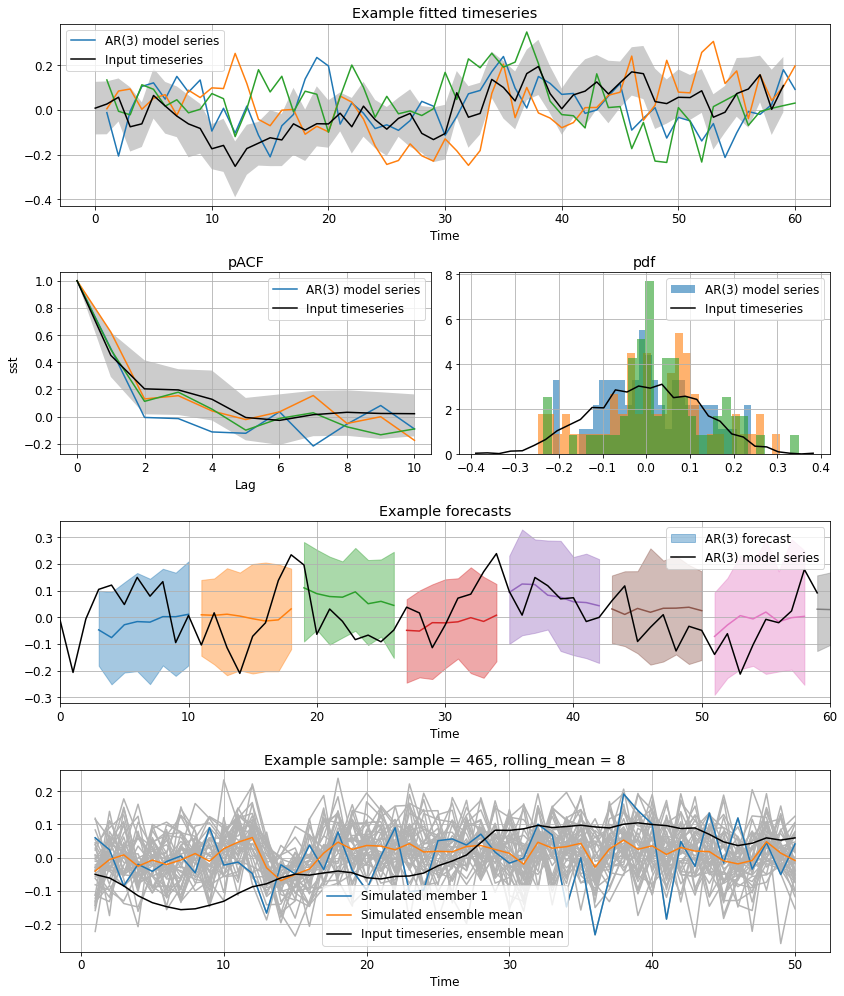

In [388]:
input_data = amv.sel(rolling_mean=1).dropna("time")

fcst = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    n_members=N_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

obsv = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

Here we focus on 8-year rolling means, which is commonplace in the literature. 

The rolling means are computed along **time** for the synthetic observations and along **lead** for the synthetic hindcasts

## The approach that has emerged as standard for inferring the significance of skill metrics in the multi-year community is a block-bootstrapping approach using a fixed blocksize of 5 points:

1. Randomly sample with replacement $N_{time}$ validation cases. To take autocorrelation into account, this is done in blocks of five consecutive cases.

2. For each case, randomly sample with replacement $N_{member}$ ensemble members.

3. Compute the required statistic for the ensemble mean (here we're interested in the ACC).

4. Repeat steps (1)–(3) $N_{permutation}$ times to create a probability distribution.

5. Obtain the significance level on the basis of a two-tailed test of the hypothesis that skill (ACC) is 0.

Let's do this for one of our pairs of synthetic observations/hindcasts

In [389]:
r, pval = stats.infer_metric(
    fcst.sel(rolling_mean=8),
    obsv.sel(rolling_mean=8),
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_permutations=1000, transform="Fisher_z"
    ),
)

In [396]:
abs(pval.where(r > 0) - 0.02).argmin().values

array(0)

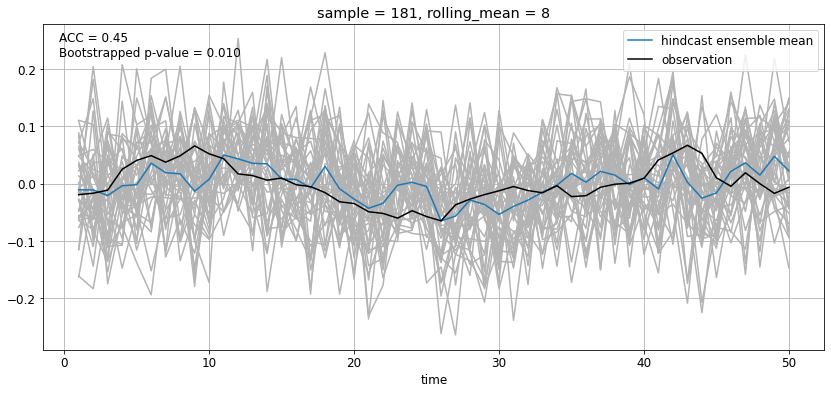

In [391]:
sample = 181

fcst_samp = fcst.sel(rolling_mean=8, sample=sample)
fcst_plot = fcst_samp - fcst_samp.mean(["time", "member"])
obsv_samp = obsv.sel(rolling_mean=8, sample=sample)
obsv_plot = obsv_samp - obsv_samp.mean("time")

fcst_plot.plot.line(
    x="time", color=[0.7, 0.7, 0.7], add_legend=False, label="_nolabel_"
)
fcst_plot.mean("member").plot(color="C0", label="hindcast ensemble mean")
obsv_plot.plot(color="k", label="observation")

r, pval = stats.infer_metric(
    fcst_samp,
    obsv_samp,
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_permutations=1000, transform="Fisher_z"
    ),
)
plt.text(
    0.02,
    0.90,
    f"ACC = {r.values:.2f}\nBootstrapped p-value = {pval.values:.3f}",
    transform=plt.gca().transAxes,
)

plt.grid()
_ = plt.legend(loc="upper right")

Most multi-year verification studies assign significance for p-values less than 0.05, so for this sample, we would say that our hindcasts are skillful. 

Of course, it's not surprising that I can find examples of high correlation in my $N_{sample}$s of synthetic signals. However, the p-value estimated by the "standard" block bootstrap approach is far too low. Actually, correlations this high occur far more often than this p-value suggests.

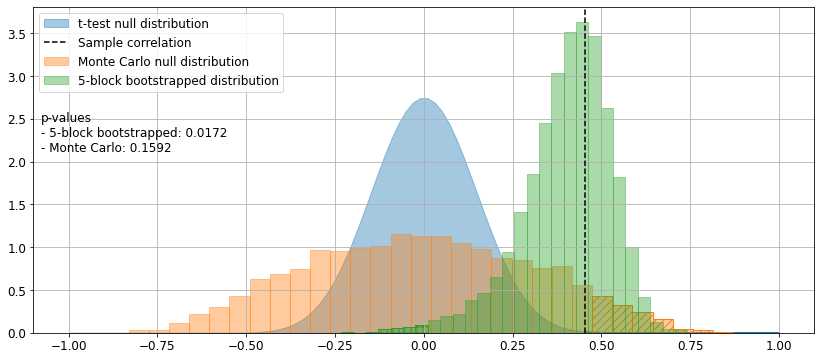

In [392]:
plot.pearson_r_distributions(
    fcst.sel(rolling_mean=8), obsv.sel(rolling_mean=8), sample, block=5
)

This is because $N_{time}$ is small and the signal ACFs are broad due to:

1. The nature of the process being assessed
2. The 8-year running averaging
3. The ensemble averaging

The effective sample size is very small and a blocksize of 5 is insufficient to account for the autocorrelation.

In [ ]:
plot.acf(
    fcst,
    amv,
    headings=["Simulated forecast", "detrended CanESM5 forecast"],
    partial=True,
    nlags=10,
)

E.g. the effective sample size estimated by

$N_{eff} = N \left( \frac{1 - \rho{f} \rho{o}}{1 + \rho{f} \rho{o}} \right)$

is:

In [230]:
import xskillscore as xs

Neff = xs.effective_sample_size(fcst.mean("member"), obsv).mean()

<xarray.DataArray ()>
array(4.2406)
Coordinates:
    rolling_mean  int64 8

The estimated blocksize estimated by Wilks is:


Things I'm battling with:
 - Hard to convince be people that there is an issue using synthetic timeseries. Actually, I think the example case above doesn't come close to bad real-world cases. But real model data isn't long enough.

Things to maybe explore:
- How do different significance tests perform?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?